## Data Processing

In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Regression analysis
import statsmodels.api as sm

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [259]:
cov_df = pd.read_csv(os.path.join(data_dir, 'covariates_weekly_fixed.csv'))
cov_df.head()

,Phase,Year_Week,R1-RF,R2-RF,R3-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
0,Recovery,1991-14,0.064083,0.240037,0.486756,-0.570730,1.150221,-0.5419,-0.869560,-0.2831,1.472018,1.9119,0.891933,0.513137,-0.032457,0.4557,1.521326
1,Recovery,1991-15,0.264305,0.625699,0.993622,0.621385,2.298820,0.2974,0.269460,0.7554,1.155684,-0.6018,0.530151,1.069284,-0.160184,1.1641,-0.205230
2,Recovery,1991-16,0.397411,0.907257,1.589490,0.369853,-0.318141,0.1628,1.181054,0.0403,0.726344,-0.6797,-2.540450,0.823179,0.438583,-0.9019,-0.383025
3,Recovery,1991-17,-0.461241,-0.400725,-0.402482,-0.120218,-1.594360,0.7819,0.109392,-0.2596,-1.943223,-0.6371,-0.758405,-1.507046,0.410131,0.1809,-0.043628
4,Recovery,1991-18,0.821113,1.524843,2.275011,0.149088,-0.747710,-0.9039,0.358368,0.0811,-1.789523,-0.6211,0.498412,0.284198,0.149900,0.3691,-0.427979


## PCA for Recovery

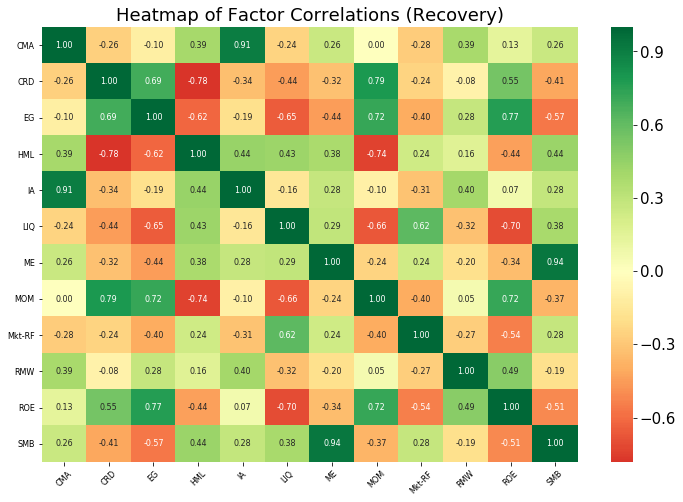

In [260]:
# check correlations for recovery
cur_phase = 'Recovery'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase]
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Recovery)')
plt.show()

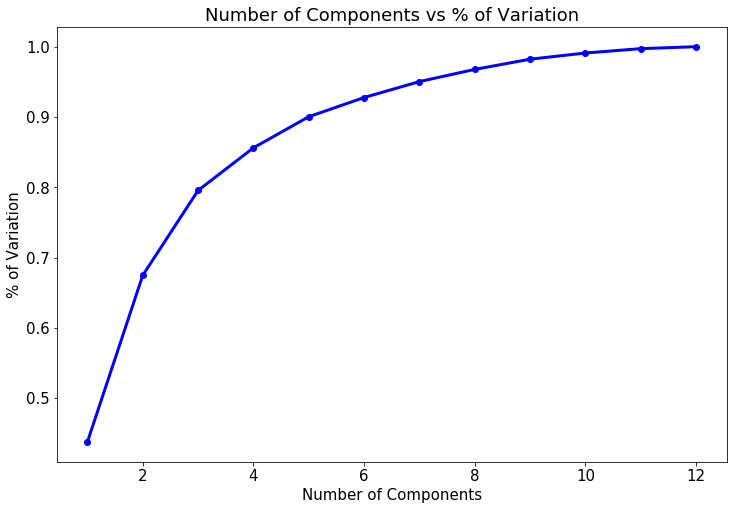

    Number of PCs  Total Variation %
0               1           0.437487
1               2           0.674585
2               3           0.795434
3               4           0.856067
4               5           0.900322
5               6           0.927648
6               7           0.950342
7               8           0.967701
8               9           0.982194
9              10           0.990998
10             11           0.997202
11             12           1.000000


In [261]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [262]:
# Number of principal components to retain
# Note: originally 6 were chosen but we adjusted it back to 5 after regression results
n_components = 5 

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0   -0.562617  0.412595 -0.338778 -0.459358 -0.234627  0.288545  1.145205   
1    0.627869  0.835259  0.232001  0.064743  0.720060  0.173816 -0.696830   
2    0.376680 -0.127736  0.140464  0.484198  0.062673  0.018102 -0.753915   
3   -0.112720 -0.597361  0.561493 -0.008909 -0.213024 -0.950105 -0.722698   
4    0.156217 -0.285809 -0.584961  0.105653  0.100180 -0.894361 -0.710973   
..        ...       ...       ...       ...       ...       ...       ...   
170  0.475657 -0.839715 -1.926186  0.744651  0.653227  0.783698  0.658480   
171  0.343087  0.249505 -0.394815  0.390330  0.063868 -0.428795  0.111373   
172  0.664648  0.162412 -0.911461  0.773985 -0.185261  1.030243  0.893122   
173 -0.083190  0.025329  0.148489  0.174501  0.309136 -0.127841  1.233214   
174 -0.202506 -0.087581 -0.272539  0.050482 -0.285740 -0.429168 -0.835475   

          MOM    Mkt-RF       RMW       ROE       SMB  


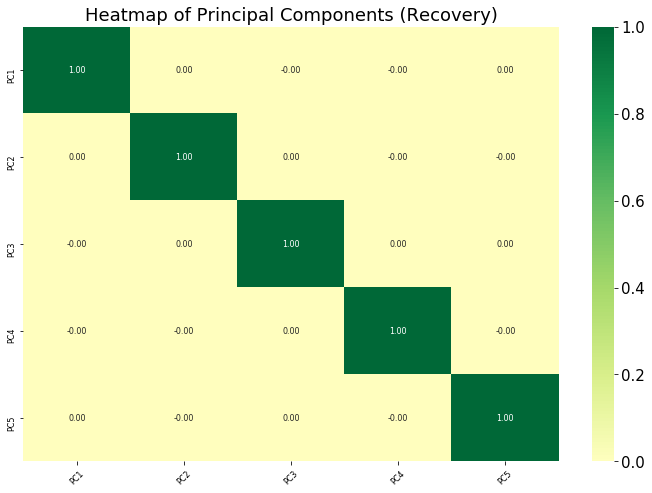

In [263]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Recovery)')
plt.show()

In [264]:
print("***** Regression on Low-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Recovery) *****


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     46.25
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           6.08e-30
Time:                        00:35:45   Log-Likelihood:                -216.15
No. Observations:                 175   AIC:                             444.3
Df Residuals:                     169   BIC:                             463.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [265]:
# write csv
recovery_df = pd.concat([cur_phase_df, PC_df], axis = 1)
recovery_df.to_csv(os.path.join(data_dir, "recovery_factor_candidates.csv"), index = False)

## PCA for Expansion

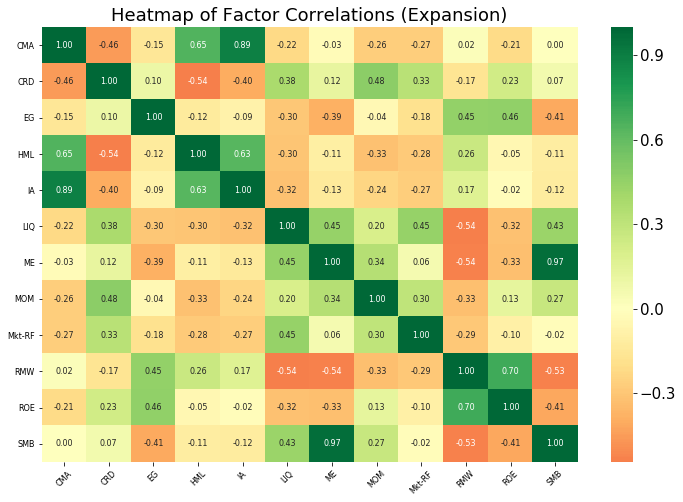

In [266]:
# check correlations for expansion
cur_phase = 'Expansion'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Expansion)')
plt.show()

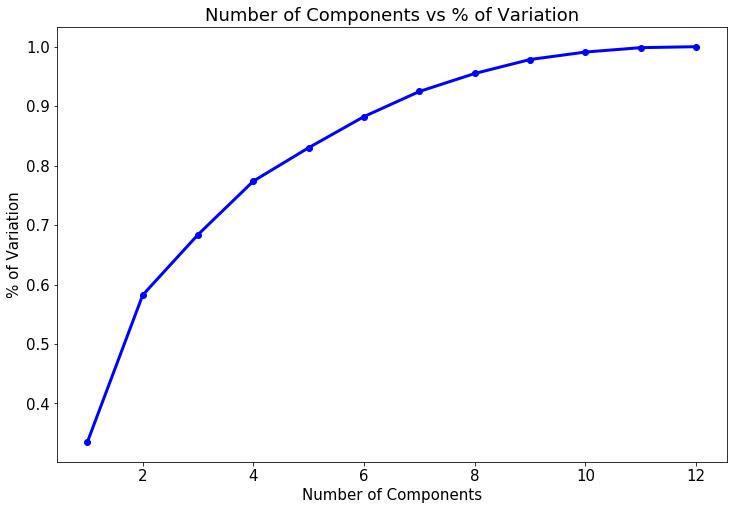

    Number of PCs  Total Variation %
0               1           0.335032
1               2           0.582303
2               3           0.683981
3               4           0.773934
4               5           0.830160
5               6           0.882501
6               7           0.924689
7               8           0.954934
8               9           0.978432
9              10           0.990985
10             11           0.998372
11             12           1.000000


In [267]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [274]:
# Number of principal components to retain
n_components = 7

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0   -0.305155  0.722682 -1.067850 -0.079636  0.149391  0.613632  0.363200   
1    0.441059 -0.084396  0.114562  0.026369  0.475364 -1.311450 -0.023784   
2   -0.444799  1.690803  0.234789 -1.125414 -0.376609 -0.416954 -0.420125   
3   -0.340068  0.015611  0.468667 -0.468583 -0.493625 -0.414029 -0.441140   
4   -1.179909  2.409378 -0.601737 -2.069618 -0.552248 -0.407570 -0.181975   
..        ...       ...       ...       ...       ...       ...       ...   
593 -1.189847 -1.094079 -1.786804  0.967689 -0.398478  0.333256 -0.131020   
594  3.472339 -2.199604 -2.044449  4.935930  3.887033  0.203194  0.600558   
595  1.278959 -1.319596 -0.286444  1.926762  1.305926 -0.681299 -0.619771   
596 -0.895177  0.216207 -0.422599 -0.888714 -0.545492 -0.331139 -0.110509   
597 -0.560009  0.107746 -0.045233 -0.638572  0.191067  1.554301  0.959762   

          MOM    Mkt-RF       RMW       ROE       SMB  


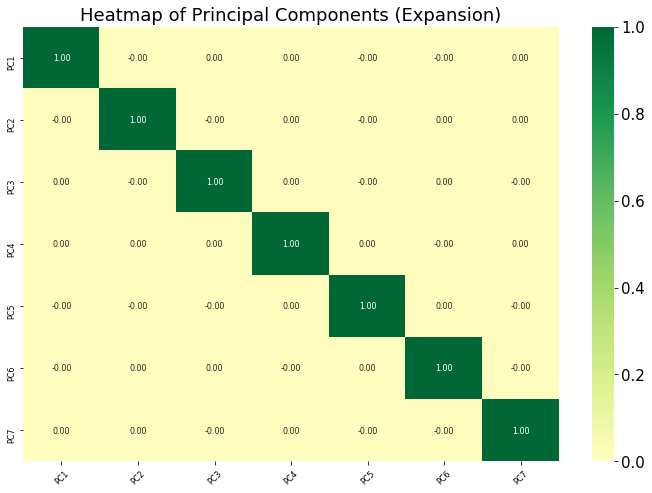

In [275]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Expansion)')
plt.show()

In [276]:
print("***** Regression on Low-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Expansion) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     191.7
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.96e-147
Time:                        00:37:14   Log-Likelihood:                -745.14
No. Observations:                 598   AIC:                             1506.
Df Residuals:                     590   BIC:                             1541.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [277]:
# write csv
expansion_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
expansion_df.to_csv(os.path.join(data_dir, "expansion_factor_candidates.csv"), index = False)

## PCA for Downturn

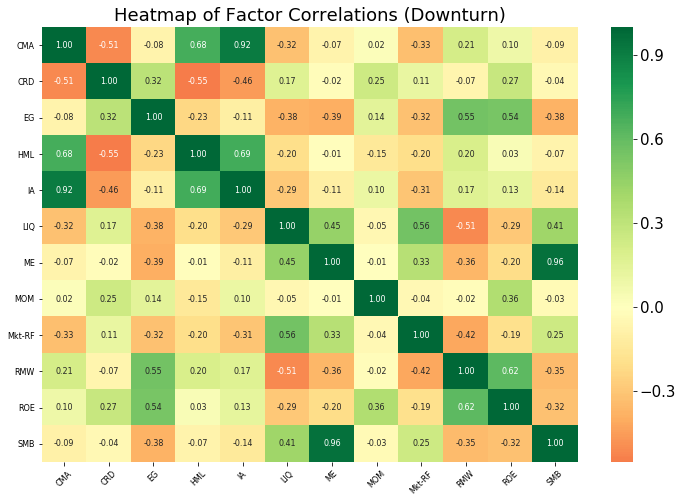

In [298]:
# check correlations for expansion
cur_phase = 'Downturn'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Downturn)')
plt.show()

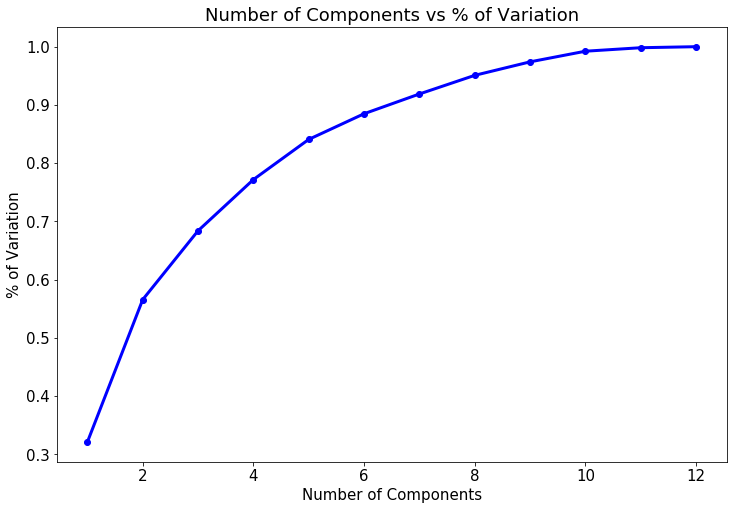

    Number of PCs  Total Variation %
0               1           0.321053
1               2           0.565639
2               3           0.683886
3               4           0.771801
4               5           0.840777
5               6           0.884856
6               7           0.918797
7               8           0.950795
8               9           0.973960
9              10           0.992237
10             11           0.998224
11             12           1.000000


In [299]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [306]:
# Number of principal components to retain
n_components = 8

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0    0.523669  0.000275  0.410183  0.018252  0.528224 -0.288952 -0.278912   
1   -0.593445  0.306625  0.370072 -0.750806 -0.321010  0.050146 -0.594608   
2   -0.341477  0.116045  1.170395 -0.109632 -0.056234  0.801613  0.294455   
3   -0.396749  1.992472 -0.070620 -0.538795  0.015779  0.732170 -0.772531   
4   -0.887165  0.058892 -0.427626 -0.162761 -0.926356  0.273924  1.285221   
..        ...       ...       ...       ...       ...       ...       ...   
663 -0.327864  0.051519  0.724453 -0.272943 -0.831267  0.186553  0.822184   
664  1.326912  0.195812 -0.100336  0.621489  1.359257 -0.342911  0.706915   
665 -4.526306  2.193640  0.554980 -2.667862 -4.159078 -2.075902 -1.245919   
666 -4.170392  1.411469 -0.079021 -4.075959 -5.477292 -0.855112 -0.980956   
667  1.541761 -0.449464 -0.839968  1.658256  1.869912 -2.104312  0.822105   

          MOM    Mkt-RF       RMW       ROE       SMB  


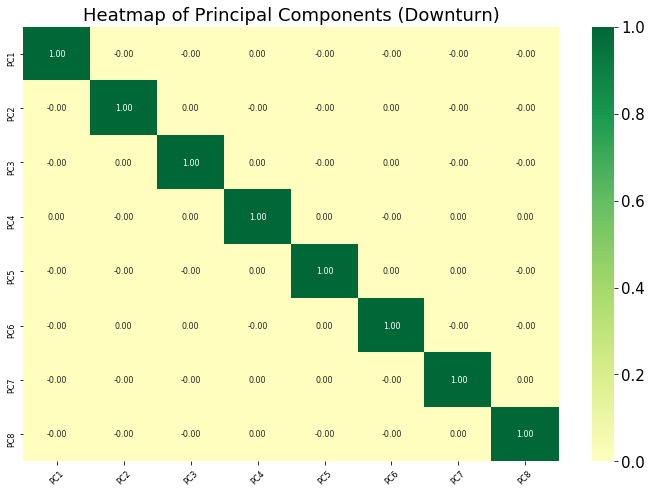

In [307]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Downturn)')
plt.show()

In [308]:
print("***** Regression on Low-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Downturn) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     198.1
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          9.82e-170
Time:                        00:40:40   Log-Likelihood:                -823.17
No. Observations:                 668   AIC:                             1664.
Df Residuals:                     659   BIC:                             1705.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [309]:
# write csv
downturn_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
downturn_df.to_csv(os.path.join(data_dir, "downturn_factor_candidates.csv"), index = False)

## PCA for Depression

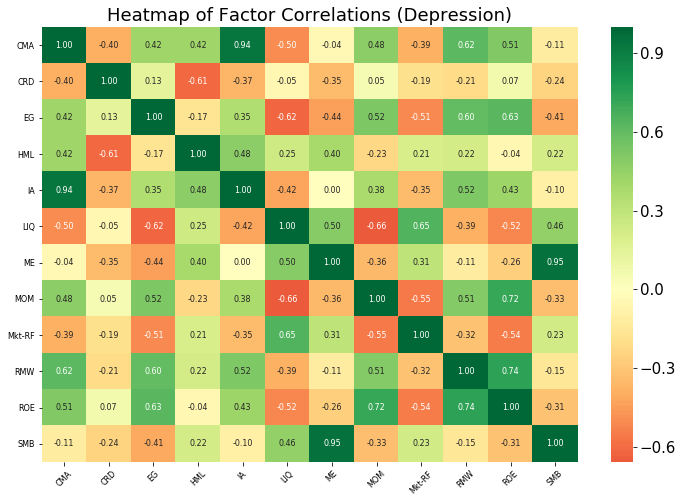

In [310]:
# check correlations for expansion
cur_phase = 'Depression'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Depression)')
plt.show()

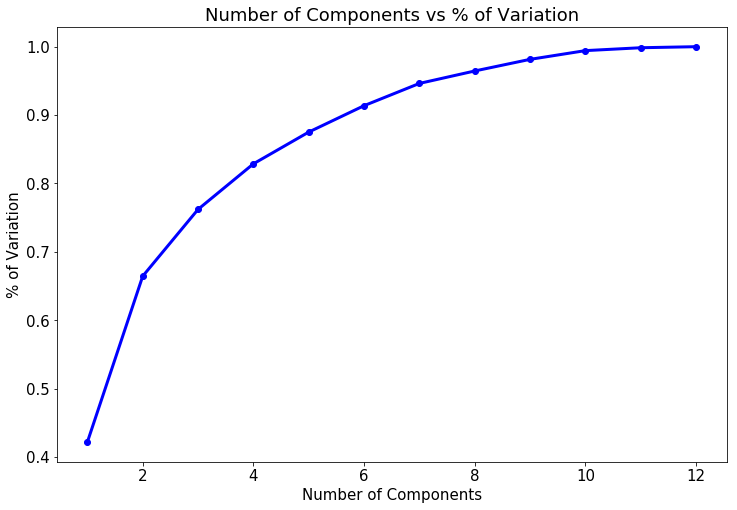

    Number of PCs  Total Variation %
0               1           0.421925
1               2           0.664464
2               3           0.762134
3               4           0.828716
4               5           0.875151
5               6           0.913750
6               7           0.946297
7               8           0.964491
8               9           0.981489
9              10           0.994252
10             11           0.998469
11             12           1.000000


In [311]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [294]:
# Number of principal components to retain
n_components = 7

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0    0.295273  0.705829  0.257231  0.710659  0.548743 -0.053634 -0.800178   
1   -1.154185  2.349829  0.371411 -0.829976 -0.432594  0.922250 -1.457399   
2    0.207638 -0.439519  0.418947 -0.085999 -0.050228 -0.058372  0.502856   
3    0.435471  0.476514  0.008587  0.233361  0.449632  0.017521 -1.426670   
4   -1.219331  0.555902 -0.722231 -0.112666 -0.761766  0.062606 -0.252723   
..        ...       ...       ...       ...       ...       ...       ...   
282 -0.434652 -0.668049 -1.334482 -0.031365 -0.252597  0.514109  0.130115   
283  1.345530 -0.750096  0.200141  0.427062  1.121901 -0.556184 -1.503337   
284 -0.184449  0.403850 -0.829989  0.134655 -0.316742  0.265217  0.735102   
285  0.298361  0.314737 -0.637966 -0.516843  0.623136 -0.228877  0.182037   
286  0.650525 -0.183457 -0.055786  0.033322  0.805401  0.018186 -0.748818   

          MOM    Mkt-RF       RMW       ROE       SMB  


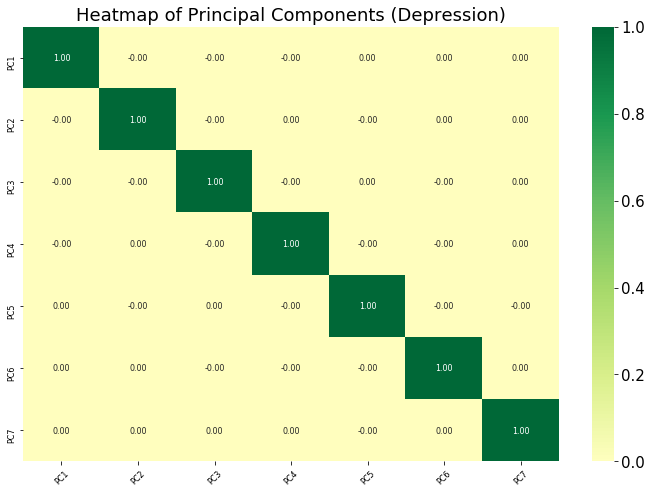

In [295]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Depression)')
plt.show()

In [296]:
print("***** Regression on Low-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Depression) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     330.1
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          5.50e-131
Time:                        00:39:18   Log-Likelihood:                -465.47
No. Observations:                 287   AIC:                             946.9
Df Residuals:                     279   BIC:                             976.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [297]:
# write csv
depression_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
depression_df.to_csv(os.path.join(data_dir, "depression_factor_candidates.csv"), index = False)